In [1]:
# General libraries
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from collections import OrderedDict, Counter
import json
import math
import warnings
warnings.filterwarnings('ignore')
import scipy.stats
import itertools

# Neural network
from keras.layers import Dropout
from keras.constraints import max_norm
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Input, Embedding, Dense, Dropout
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error

# Data processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_score, KFold

# Model training
from sklearn.metrics import mean_absolute_error, plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans
import xgboost as xgb
import pickle

# Utils files
sys.path.insert(0, '../src/scripts')
from utils import ProcessData, Predict

Using TensorFlow backend.


In [2]:
def params_name_format(params, str_rem):
    out_dict = {}
    for k, v in params.items():
        new_key = k.replace(str_rem, '') if str_rem in k else k
        out_dict[new_key] = v
    return out_dict 

def prediction_score(xgb_model, X_val, gt, tr):
    pred = xgb_model.predict(X_val)
    gt_res = gt.copy()
    for idx, transfo in enumerate(tr):
        if transfo =='Squared':
            gt_res.iloc[:,idx] = np.squeeze(np.square(list(gt.iloc[:,idx])))
            pred[:,idx] = np.squeeze(np.square(pred[:,idx]))
        elif transfo == 'Log':
            gt_res.iloc[:,idx] = np.squeeze(np.expm1(list(gt.iloc[:,idx])))
            pred[:,idx] = np.squeeze(np.expm1(pred[:,idx]))
        else:
            gt_res.iloc[:,idx] = np.squeeze(list(gt.iloc[:,idx]))
            pred[:,idx] = np.squeeze(pred[:,idx])
    return gt_res, pred

def prediction_price(xgb_model, X_val, gt, tr):
    pred = np.expand_dims(xgb_model.predict(X_val), axis=1)
    for idx, transfo in enumerate(tr):
        if transfo =='Squared':
            gt, pred = np.squeeze(np.square(list(gt.iloc[:,idx]))), np.squeeze(np.square(pred[:,idx]))
        elif transfo == 'Log':
            gt, pred = np.squeeze(np.expm1(list(gt.iloc[:,idx]))), np.squeeze(np.expm1(pred[:,idx]))
        else:
            gt, pred = np.squeeze(list(gt.iloc[:,idx])), np.squeeze(pred[:,idx])
    return gt, pred

def plot_results(gt, pred, tr):
    # Predict target values
    plt.figure(figsize=(20,10))
    d = {'Ground truth': gt, 'Pred': pred}
    res_pred = pd.DataFrame(data=d).reset_index()

    # Plotting results
    plt.plot(res_pred[['Ground truth']],'b-', label='Ground truth')
    plt.plot(res_pred[['Pred']],'r-', label='ML prediction')
    plt.xlabel('Occurence', fontsize=15)
    plt.ylabel('Sale price prediction', fontsize=15)

    x = [1e7,2e7,3e7,4e7,5e7,6e7,7e7,8e7,9e7,1e8]
    labels = ['1.000','2.000','3.000','4.000','5.000','6.000','7.000','8.000','9.000','10.000']
    plt.yticks(x, labels,fontsize=13)
    plt.title('House sale price prediction - MAE = %s ¥ - %s'%(format(int(mean_absolute_error(gt, pred)),',d'),tr), fontsize=20)
    plt.legend(fontsize=15)
    
    return int(mean_absolute_error(gt, pred))

# PWS data processing

In [3]:
base_params = '../src/params'
base_models = '../src/models'
base_data = '../mansion_fit/mansionfit_2020-12-02.csv'
base_eval = '../src/data/evaluation'

In [4]:
data = ProcessData()

params_ml, _, area_data = data.load_json_file(base_params)
pws, _, _ = data.create_user_buildings_df(base_data, area_data)

master_cities = pd.read_csv(os.path.join(base_data,'master_cities.csv')).dropna()

(10692, 45)


In [5]:
pws.head(1)

age_type  real_age_type  income_type  real_income_type  \
user_id                                                           
3058098      45.0           53.0         1500          15000000   

         monthly_rent_type  family_type  home_city_code  office_city_code  \
user_id                                                                     
3058098           180000.0            2         13117.0           13104.0   

               building_id         name     price  width  mf_floor_plan_type  \
user_id                                                                        
3058098  31110031-31110031  ザ・ガーデンズ東京王子  55899100  70.56                 4.0   

         search_area_code search_area_name  area_code  Unnamed: 0    api_lat  \
user_id                                                                        
3058098              1303        東京23区東エリア       1303         0.0  35.763803   

            api_lon                                             adress   pref  \
user_id                                                                         
3058098  139.726858  3-chōme-18-51 Higashijūjō, Kita City, Tokyo 11...  Tokyo   

        walking_station name_station  leisure  beauty care  administrative  \
user_id                                                                      
3058098            1,11     東十条駅,十条駅     18.0         39.0            29.0   

         transportation  shopping  living  health care  park  education  food  \
user_id                                                                         
3058098             2.0      31.0    35.0         64.0  20.0       23.0  60.0   

         station number  average walking time  walking_score  \
user_id                                                        
3058098               2                   6.0       0.333333   

         spaciosity_score  family_score  price_score  environment_score  \
user_id                                                                   
3058098             11.76           0.5     1.979638               32.1   

         walking_score_raw  spaciosity_score_raw  family_score_raw  \
user_id                                                              
3058098           0.333333                 11.76               0.5   

         price_score_raw  environment_score_raw  
user_id                                          
3058098         1.979638                   32.1

# MF input shape

In [6]:
def create_encoding_code(pws, cities, categorical_col):
    home_missing_code = list(set(pws['home_city_code']).symmetric_difference(set(cities['code'])))
    office_missing_code = list(set(pws['office_city_code']).symmetric_difference(set(cities['code'])))
    
    if len(home_missing_code) > len(office_missing_code):
        d = len(home_missing_code) - len(office_missing_code)
        hm = []
        of = [13107 for i in range(d)]
    elif len(home_missing_code) < len(office_missing_code):
        d = len(office_missing_code) - len(home_missing_code)
        hm = [home_missing_code[-1] for i in range(d)]
        of = []
    else:
        hm = []
        of = []
    dummy = pd.DataFrame(columns = categorical_col)
    dummy['home_city_code'] = home_missing_code + hm
    dummy['office_city_code'] = office_missing_code + of
    dummy['family_type'] = [1 for i in range(max(len(home_missing_code),len(office_missing_code)))]
    dummy.index = ['dummy' for i in range(dummy.shape[0])]
    data_dummy = pd.concat([pws[categorical_col], dummy], axis=0)
    return data_dummy

continuous_col = ['age_type','monthly_rent_type','income_type']
categorical_col = ['family_type', 'home_city_code', 'office_city_code']

data_continuous, transform_min, mean, std = data.skew_processing(pws[continuous_col])
data_continuous = data.normalization(data_continuous,'mean')

if 'encoder.obj' not in os.listdir(base_models):
    # Add all cities code to data
    index_list = pws.head()
    data_dummy = create_encoding_code(pws, master_cities, categorical_col)

    # Encode with real and dummy data
    encoder = OneHotEncoder(dtype=np.int, sparse=True)
    data_categorical = pd.DataFrame(encoder.fit_transform(data_dummy).toarray(),
                                    columns = [i for i in encoder.get_feature_names()],
                                    index = data_dummy.index)
    # Save encoder
    filehandler = open(os.path.join(base_models,'encoder.obj'),"wb")
    pickle.dump(encoder,filehandler)
    filehandler.close()
else:
    file = open(os.path.join(base_models,'encoder.obj'),'rb')
    encoder = pickle.load(file)
    data_categorical = pd.DataFrame(encoder.transform(pws[categorical_col]).toarray(),
                                    columns = [i for i in encoder.get_feature_names()],
                                    index = pws.index)

# Select only data with non-dummy index
d = pd.concat([data_continuous, data_categorical[data_categorical.index.isin(data_continuous.index)]], axis=1)

# Save mean, std, columns name in ml_params
params_ml['variables']['pre-process']['continuous_col'] = continuous_col
params_ml['variables']['pre-process']['categorical_col'] = categorical_col
params_ml['variables']['pre-process']['mean'] = [list(mean)]
params_ml['variables']['pre-process']['std'] = list(std)
params_ml['variables']['pre-process']['transformation'] = transform_min

with open(os.path.join(base_params,'ml_params.json'), 'w') as outfile:
    json.dump(params_ml, outfile)

d.head()

age_type  monthly_rent_type  income_type  x0_1  x0_2  x0_3  x0_99  \
3058098  1.420318           1.195702     2.145113     0     1     0      0   
3337222  1.420318           1.195702     1.089503     1     0     0      0   
3380780  1.420318           1.195702     2.145113     0     1     0      0   
3392851  1.420318          -0.138784     1.089503     0     1     0      0   
3644620  1.420318           1.195702     2.145113     0     1     0      0   

         x1_1100.0  x1_1101.0  x1_1102.0  x1_1103.0  x1_1104.0  x1_1105.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1106.0  x1_1107.0  x1_1108.0  x1_1109.0  x1_1110.0  x1_1202.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1203.0  x1_1204.0  x1_1205.0  x1_1206.0  x1_1207.0  x1_1208.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1209.0  x1_1210.0  x1_1211.0  x1_1212.0  x1_1213.0  x1_1214.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1215.0  x1_1216.0  x1_1217.0  x1_1218.0  x1_1219.0  x1_1220.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1221.0  x1_1222.0  x1_1223.0  x1_1224.0  x1_1225.0  x1_1226.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1227.0  x1_1228.0  x1_1229.0  x1_1230.0  x1_1231.0  x1_1233.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1234.0  x1_1235.0  x1_1236.0  x1_1303.0  x1_1304.0  x1_1331.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0      

# ML - User cluster

In [7]:
# _, _, area_data = data.load_json_file(base_params)
# _, users_df, _ = data.create_user_buildings_df(base_data, area_data)
# users_data = data.prepare_input_data(users_df, params_ml, base_models)

model = KMeans(n_clusters=7, random_state=5)
train = model.fit(d)

In [8]:
pickle.dump(train, open(os.path.join(base_models,'user_cluster_model.pkl'), "wb"))

# ML - Price regression

age_type  monthly_rent_type  income_type  x0_1  x0_2  x0_3  x0_99  \
3058098  1.420318           1.195702     2.145113     0     1     0      0   
3337222  1.420318           1.195702     1.089503     1     0     0      0   
3380780  1.420318           1.195702     2.145113     0     1     0      0   
3392851  1.420318          -0.138784     1.089503     0     1     0      0   
3644620  1.420318           1.195702     2.145113     0     1     0      0   

         x1_1100.0  x1_1101.0  x1_1102.0  x1_1103.0  x1_1104.0  x1_1105.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1106.0  x1_1107.0  x1_1108.0  x1_1109.0  x1_1110.0  x1_1202.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1203.0  x1_1204.0  x1_1205.0  x1_1206.0  x1_1207.0  x1_1208.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1209.0  x1_1210.0  x1_1211.0  x1_1212.0  x1_1213.0  x1_1214.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1215.0  x1_1216.0  x1_1217.0  x1_1218.0  x1_1219.0  x1_1220.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1221.0  x1_1222.0  x1_1223.0  x1_1224.0  x1_1225.0  x1_1226.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1227.0  x1_1228.0  x1_1229.0  x1_1230.0  x1_1231.0  x1_1233.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1234.0  x1_1235.0  x1_1236.0  x1_1303.0  x1_1304.0  x1_1331.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0      

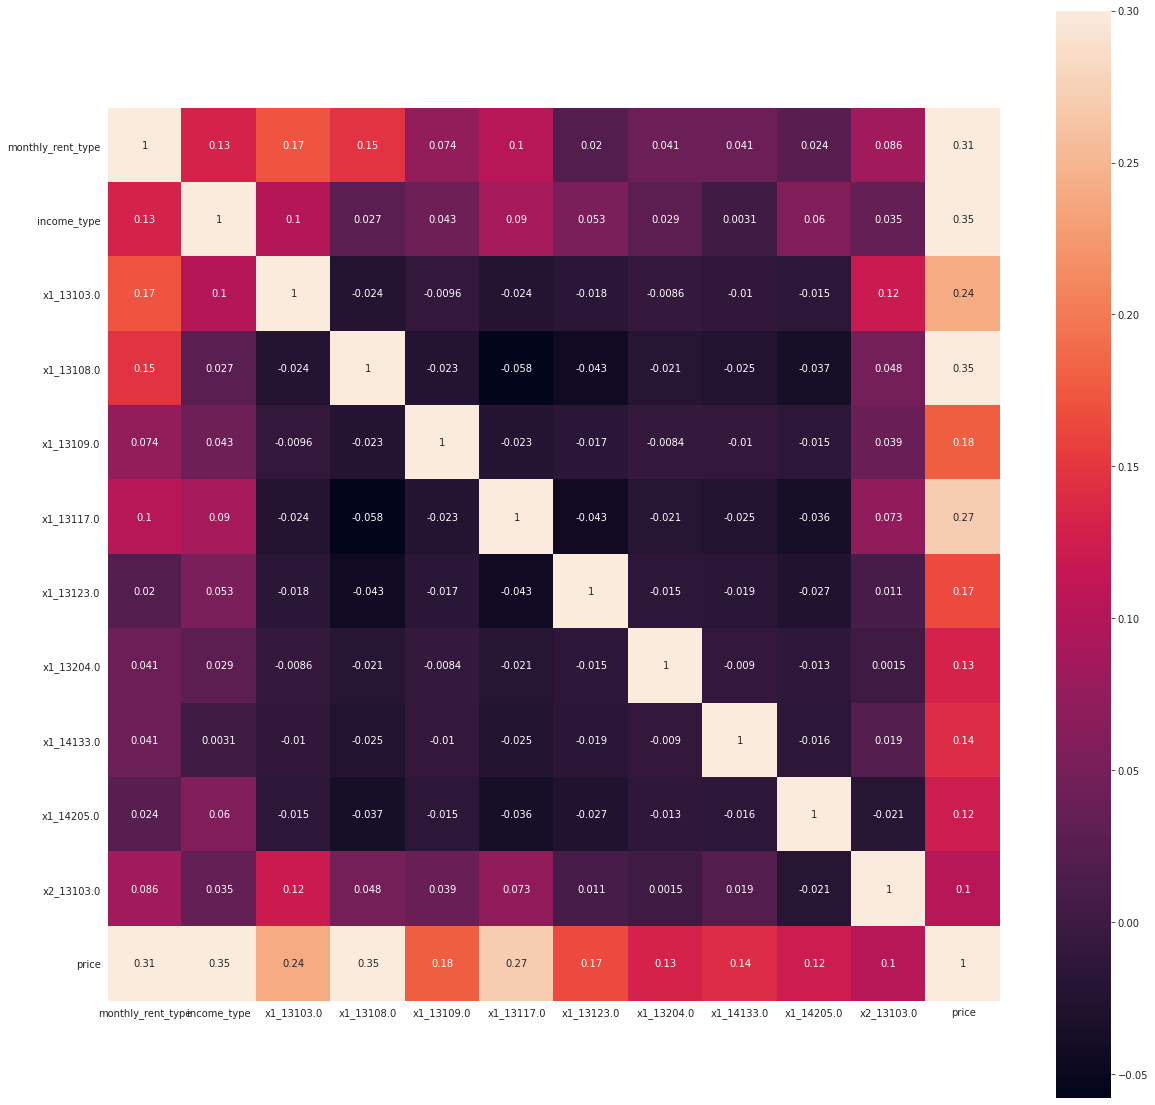

In [9]:
target_col_price = ['price']

data_target, transform_price, _, _ = data.skew_processing(pws[target_col_price])
input_data = pd.concat([d, data_target, pws[['search_area_code']]], axis=1)

corr = input_data.corr()
cor_target = corr[target_col_price].drop(labels=target_col_price)
train_col_price = list(cor_target[(cor_target >= 0.1).any(1)].index)
train_col_price = [i for i in train_col_price if i not in ['search_area_code']]

corr = pd.concat([input_data[train_col_price],input_data[target_col_price]],axis=1).corr()

plt.figure(figsize=(20,20))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, vmax=.3, square=True, annot=True)

X_train_price, X_val_price, y_train_price, y_val_price = train_test_split(input_data[train_col_price],
                                                                          input_data[target_col_price],
                                                                          stratify=input_data['search_area_code'],
                                                                          test_size=0.15, 
                                                                          random_state=10, 
                                                                          shuffle=True)
# Remove startified column
input_data = input_data.drop(['search_area_code'], 1)

# Save price train col in ml_params
params_ml, _, _ = data.load_json_file(base_params)
params_ml['variables']['target']['price_col'] = target_col_price
params_ml['variables']['target']['transformation_price'] = transform_price
params_ml['variables']['train']['price'] = train_col_price

with open(os.path.join(base_params,'ml_params.json'), 'w') as outfile:
    json.dump(params_ml, outfile)

id_val = list(X_val_price.index)
id_dict = {'user_val_id': id_val}

with open(os.path.join(base_eval,'user_id_val.json'), 'w') as outfile:
    json.dump(id_dict, outfile)

input_data.head()

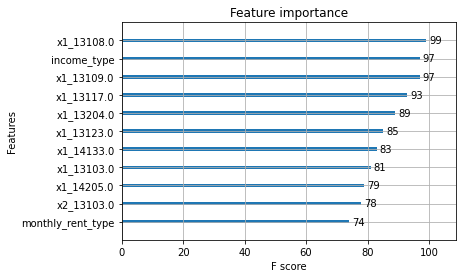

In [10]:
params_xgb = {'colsample_bytree': 0.1, 'eval_metric': 'rmse', 'learning_rate': 0.1, 'max_depth': 1,
              'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'reg:squarederror',
              'subsample': 0.1}

xgb_model_price = xgb.XGBRegressor(**params_xgb).fit(X_train_price, y_train_price)

xgb.plot_importance(xgb_model_price)
plt.show()

In [11]:
pickle.dump(xgb_model_price, open(os.path.join(base_models,'price_model.pkl'), "wb"))

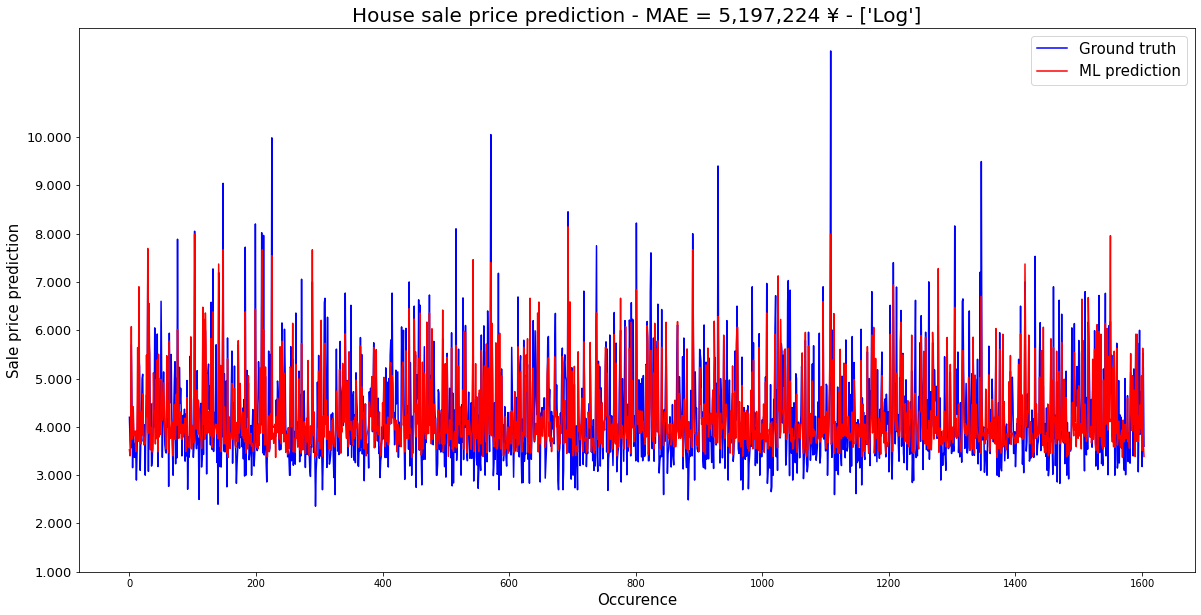

In [12]:
gt, pred = prediction_price(xgb_model_price, X_val_price, y_val_price, transform_price)
mae_price = plot_results(gt, pred, transform_price)

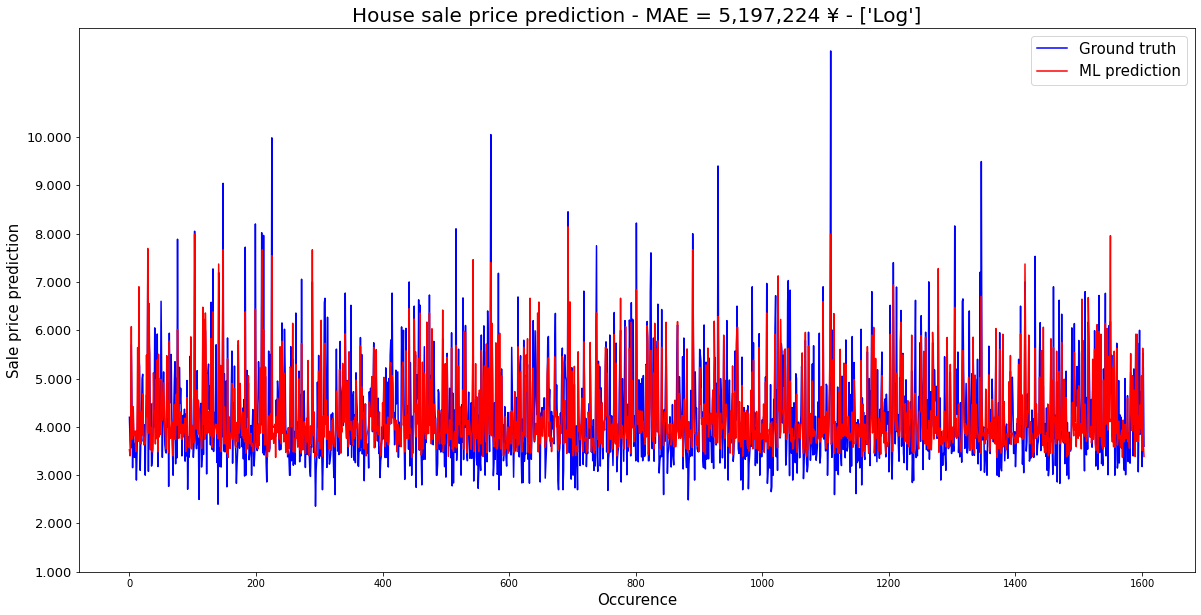

In [13]:
params_ml, _, _ = data.load_json_file(base_params)
_, price_md, _, _ = data.load_models(base_models)

pred = Predict()
p = np.array(pred.predict_price(price_md, X_val_price, params_ml))

transform_price = params_ml['variables']['target']['transformation_price']
gt, _ = prediction_price(xgb_model_price, X_val_price, y_val_price, transform_price)
mae_price = plot_results(gt, p, transform_price)

In [14]:
# Save price error in ml_params
params_ml, _, _ = data.load_json_file(base_params)
params_ml['variables']['error']['price'] = mae_price

with open(os.path.join(base_params,'ml_params.json'), 'w') as outfile:
    json.dump(params_ml, outfile)

# ML - Score regression

age_type  monthly_rent_type  income_type  x0_1  x0_2  x0_3  x0_99  \
3058098  1.420318           1.195702     2.145113     0     1     0      0   
3337222  1.420318           1.195702     1.089503     1     0     0      0   
3380780  1.420318           1.195702     2.145113     0     1     0      0   
3392851  1.420318          -0.138784     1.089503     0     1     0      0   
3644620  1.420318           1.195702     2.145113     0     1     0      0   

         x1_1100.0  x1_1101.0  x1_1102.0  x1_1103.0  x1_1104.0  x1_1105.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1106.0  x1_1107.0  x1_1108.0  x1_1109.0  x1_1110.0  x1_1202.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1203.0  x1_1204.0  x1_1205.0  x1_1206.0  x1_1207.0  x1_1208.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1209.0  x1_1210.0  x1_1211.0  x1_1212.0  x1_1213.0  x1_1214.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1215.0  x1_1216.0  x1_1217.0  x1_1218.0  x1_1219.0  x1_1220.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1221.0  x1_1222.0  x1_1223.0  x1_1224.0  x1_1225.0  x1_1226.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1227.0  x1_1228.0  x1_1229.0  x1_1230.0  x1_1231.0  x1_1233.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1234.0  x1_1235.0  x1_1236.0  x1_1303.0  x1_1304.0  x1_1331.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0      

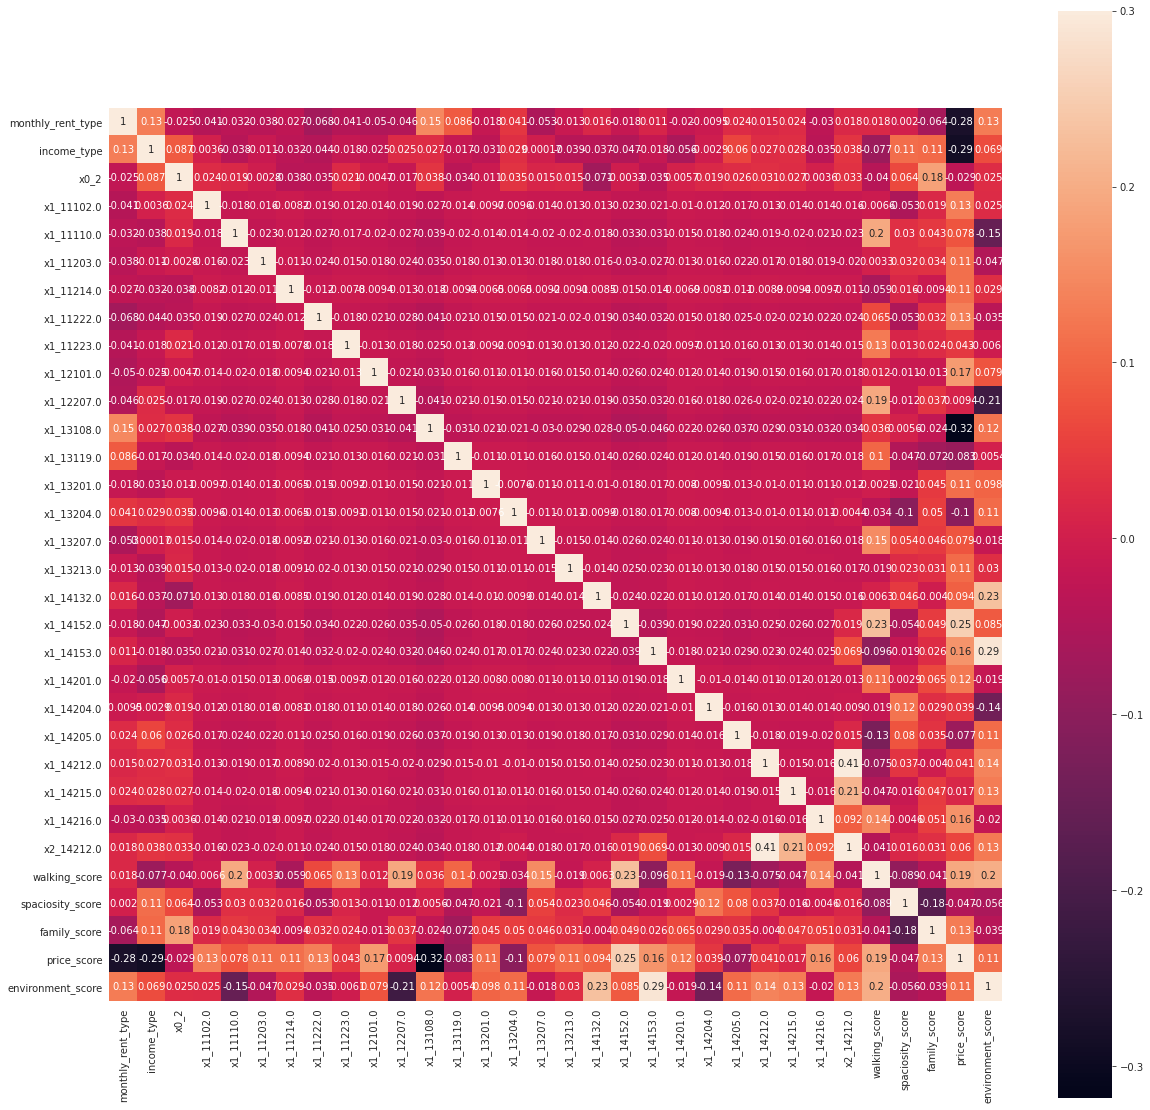

In [15]:
target_col_score = ['walking_score','spaciosity_score','family_score','price_score','environment_score']

data_target, transform_score, _, _ = data.skew_processing(pws[target_col_score])
input_data = pd.concat([d, data_target, pws['search_area_code']], axis=1)

corr = input_data.corr()
cor_target = corr[target_col_score].drop(labels=target_col_score)
train_col_score = list(cor_target[(cor_target >= 0.1).any(1)].index)
train_col_score = [i for i in train_col_score if i !='search_area_code']
corr = pd.concat([input_data[train_col_score],input_data[target_col_score]],axis=1).corr()

plt.figure(figsize=(20,20))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, vmax=.3, square=True, annot=True)

X_train_score, X_val_score, y_train_score, y_val_score = train_test_split(input_data[train_col_score],
                                                                          input_data[target_col_score],
                                                                          stratify=input_data['search_area_code'],
                                                                          test_size=0.15, 
                                                                          random_state=10, 
                                                                          shuffle=True)
# Remove startified column
input_data = input_data.drop('search_area_code', 1)

# Save score train col in ml_params
params_ml, _, _ = data.load_json_file(base_params)
params_ml['variables']['target']['score_col'] = target_col_score
params_ml['variables']['target']['transformation_score'] = transform_score
params_ml['variables']['train']['score'] = train_col_score

with open(os.path.join(base_params,'ml_params.json'), 'w') as outfile:
    json.dump(params_ml, outfile)

input_data.head()

In [16]:
params_xgb = {'eval_metric': 'rmse',
              'subsample': 0.4,
              'learning_rate': 0.1,
              'min_child_weight': 5,
              'colsample_bytree': 0.5,
              'objective': 'reg:squarederror',
              'n_estimators': 1000,
              'max_depth': 5}

xgb_model_score = MultiOutputRegressor(xgb.XGBRegressor(**params_xgb)).fit(X_train_score, y_train_score)

In [17]:
pickle.dump(xgb_model_score, open(os.path.join(base_models,'score_model.pkl'), "wb"))

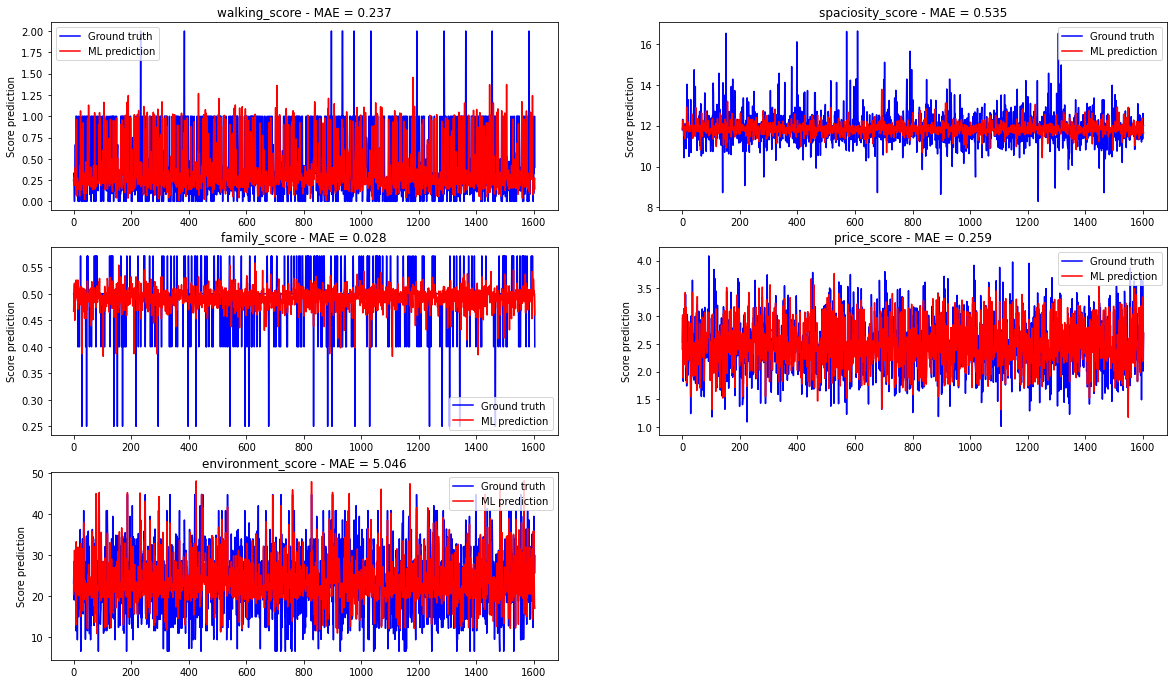

In [18]:
params_ml, _, _ = data.load_json_file(base_params)
_, _, _, score_md = data.load_models(base_models)

gt_res, _ = prediction_score(xgb_model_score, X_val_score, y_val_score, transform_score)

pred = Predict()
p = pred.predict_score(score_md, X_val_score, params_ml)

score_error_dict = {}
plt.figure(figsize=(20,20))
for idx, target in enumerate(target_col_score):
    gt = gt_res.loc[:,target]
    y_pred = np.transpose(p)[idx]
    
    df = {'Ground truth': gt, 'Pred': y_pred}
    res_pred = pd.DataFrame(data=df).reset_index()
    
    mae = mean_absolute_error(gt, y_pred)
    score_error_dict[target] = mae
    
    plt.subplot(5,2,idx+1)
    plt.plot(res_pred[['Ground truth']],'b-', label='Ground truth')
    plt.plot(res_pred[['Pred']],'r-', label='ML prediction')
    plt.ylabel('Score prediction')
    plt.title('%s - MAE = %s'%(target, round(mae, 3)))
    plt.legend()

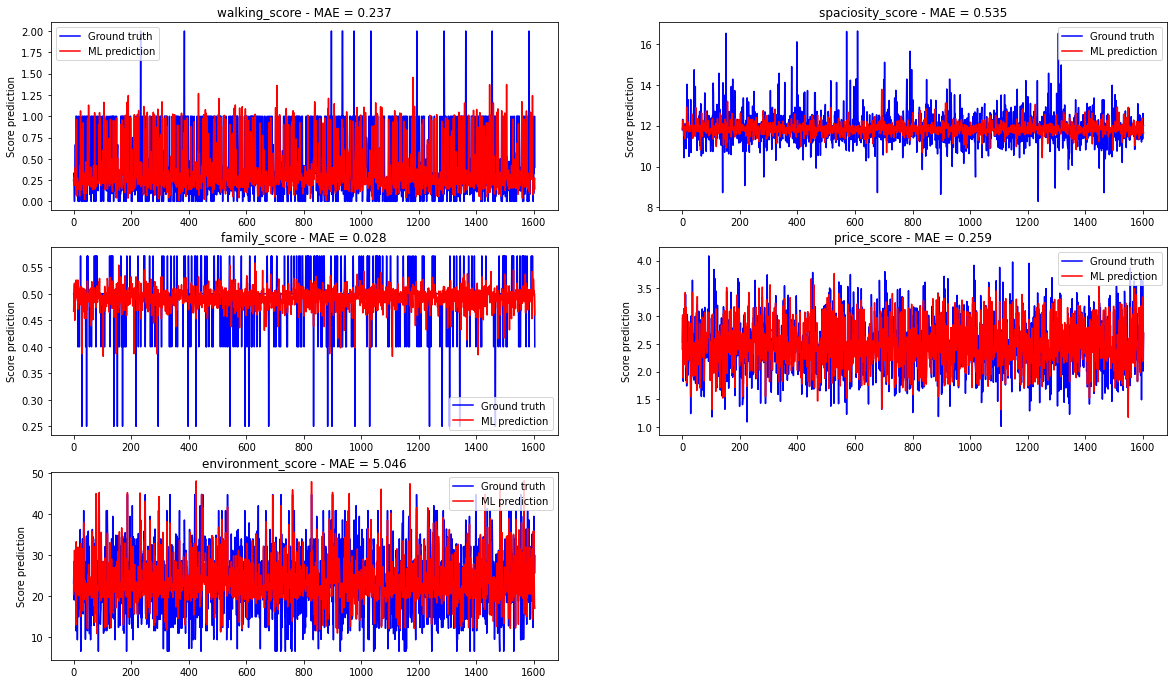

In [19]:
gt_res, pred = prediction_score(xgb_model_score, X_val_score, y_val_score, transform_score)

score_error_dict = {}
plt.figure(figsize=(20,20))
for idx, target in enumerate(target_col_score):
    gt = gt_res.loc[:,target]
    y_pred = np.round(np.transpose(pred)[idx],3).tolist()
    
    df = {'Ground truth': gt, 'Pred': y_pred}
    res_pred = pd.DataFrame(data=df).reset_index()
    
    mae = mean_absolute_error(gt, y_pred)
    score_error_dict[target] = mae
    
    plt.subplot(5,2,idx+1)
    plt.plot(res_pred[['Ground truth']],'b-', label='Ground truth')
    plt.plot(res_pred[['Pred']],'r-', label='ML prediction')
    plt.ylabel('Score prediction')
    plt.title('%s - MAE = %s'%(target, round(mae, 3)))
    plt.legend()

In [20]:
# Save price error in ml_params
params_ml, _, _ = data.load_json_file(base_params)
params_ml['variables']['error']['score'] = score_error_dict

with open(os.path.join(base_params,'ml_params.json'), 'w') as outfile:
    json.dump(params_ml, outfile)

# ML - Area classification

## By search area  code

In [21]:
target_col_search_area = ['search_area_code']
input_data = pd.concat([d, pws[target_col_search_area]], axis=1)
train_col_search_area = [i for i in input_data.columns if i not in target_col_search_area]

X_train_search_area, X_val_search_area, y_train_search_area, y_val_search_area = train_test_split(input_data[train_col_search_area],
                                                                                                  input_data[target_col_search_area],
                                                                                                  stratify=input_data[target_col_search_area],
                                                                                                  test_size=0.15, 
                                                                                                  random_state=10, 
                                                                                                  shuffle=True)
# Save score train col in ml_params
params_ml, _, _ = data.load_json_file(base_params)
params_ml['variables']['train']['area'] = train_col_search_area

with open(os.path.join(base_params,'ml_params.json'), 'w') as outfile:
    json.dump(params_ml, outfile)

input_data.head()

age_type  monthly_rent_type  income_type  x0_1  x0_2  x0_3  x0_99  \
3058098  1.420318           1.195702     2.145113     0     1     0      0   
3337222  1.420318           1.195702     1.089503     1     0     0      0   
3380780  1.420318           1.195702     2.145113     0     1     0      0   
3392851  1.420318          -0.138784     1.089503     0     1     0      0   
3644620  1.420318           1.195702     2.145113     0     1     0      0   

         x1_1100.0  x1_1101.0  x1_1102.0  x1_1103.0  x1_1104.0  x1_1105.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1106.0  x1_1107.0  x1_1108.0  x1_1109.0  x1_1110.0  x1_1202.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1203.0  x1_1204.0  x1_1205.0  x1_1206.0  x1_1207.0  x1_1208.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1209.0  x1_1210.0  x1_1211.0  x1_1212.0  x1_1213.0  x1_1214.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1215.0  x1_1216.0  x1_1217.0  x1_1218.0  x1_1219.0  x1_1220.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1221.0  x1_1222.0  x1_1223.0  x1_1224.0  x1_1225.0  x1_1226.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1227.0  x1_1228.0  x1_1229.0  x1_1230.0  x1_1231.0  x1_1233.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0          0   
3392851          0          0          0          0          0          0   
3644620          0          0          0          0          0          0   

         x1_1234.0  x1_1235.0  x1_1236.0  x1_1303.0  x1_1304.0  x1_1331.0  \
3058098          0          0          0          0          0          0   
3337222          0          0          0          0          0          0   
3380780          0          0          0          0          0      

In [22]:
params_xgb = {'subsample': 0.4,
              'learning_rate': 0.1,
              'min_child_weight': 5,
              'colsample_bytree': 0.5,
              'objective': 'multi:softprob',
              'n_estimators': 1000,
              'max_depth': 5}

xgb_model_search_area = xgb.XGBClassifier(**params_xgb).fit(X_train_search_area, y_train_search_area)

y_pred_search_area = xgb_model_search_area.predict(X_val_search_area)
accuracy_search_area = accuracy_score(y_val_search_area, y_pred_search_area)
print("Accuracy: %s"%(round(accuracy_search_area,3)))

Accuracy: 0.921


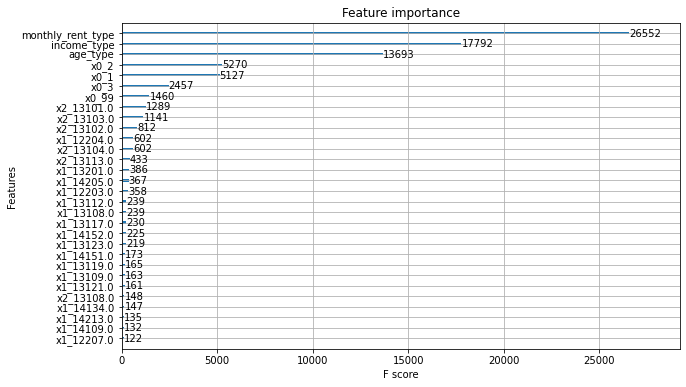

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
xgb.plot_importance(xgb_model_search_area, max_num_features=30, ax=ax)
plt.show()

In [24]:
pickle.dump(xgb_model_search_area, open(os.path.join(base_models,'area_model_by_search_area.pkl'), "wb"))

In [25]:
def plot_confusion_matrix_pred(cm, target_names, cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('accuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

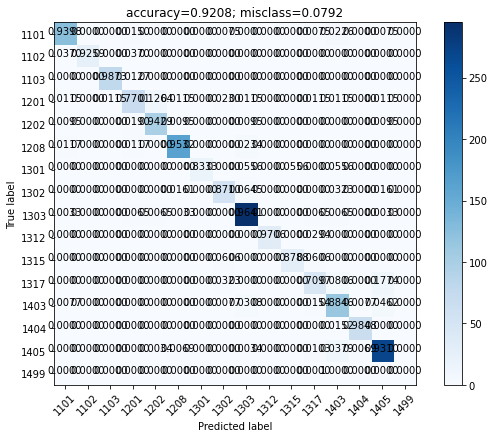

In [26]:
params_ml, _, _ = data.load_json_file(base_params)
_, _, area_md, _ = data.load_models(base_models)

pred = Predict()
p = pred.predict_area(area_md, X_val_search_area, params_ml)

cm = confusion_matrix(y_val_search_area,p)
plot_confusion_matrix_pred(cm = cm, target_names = np.unique(y_val_search_area))

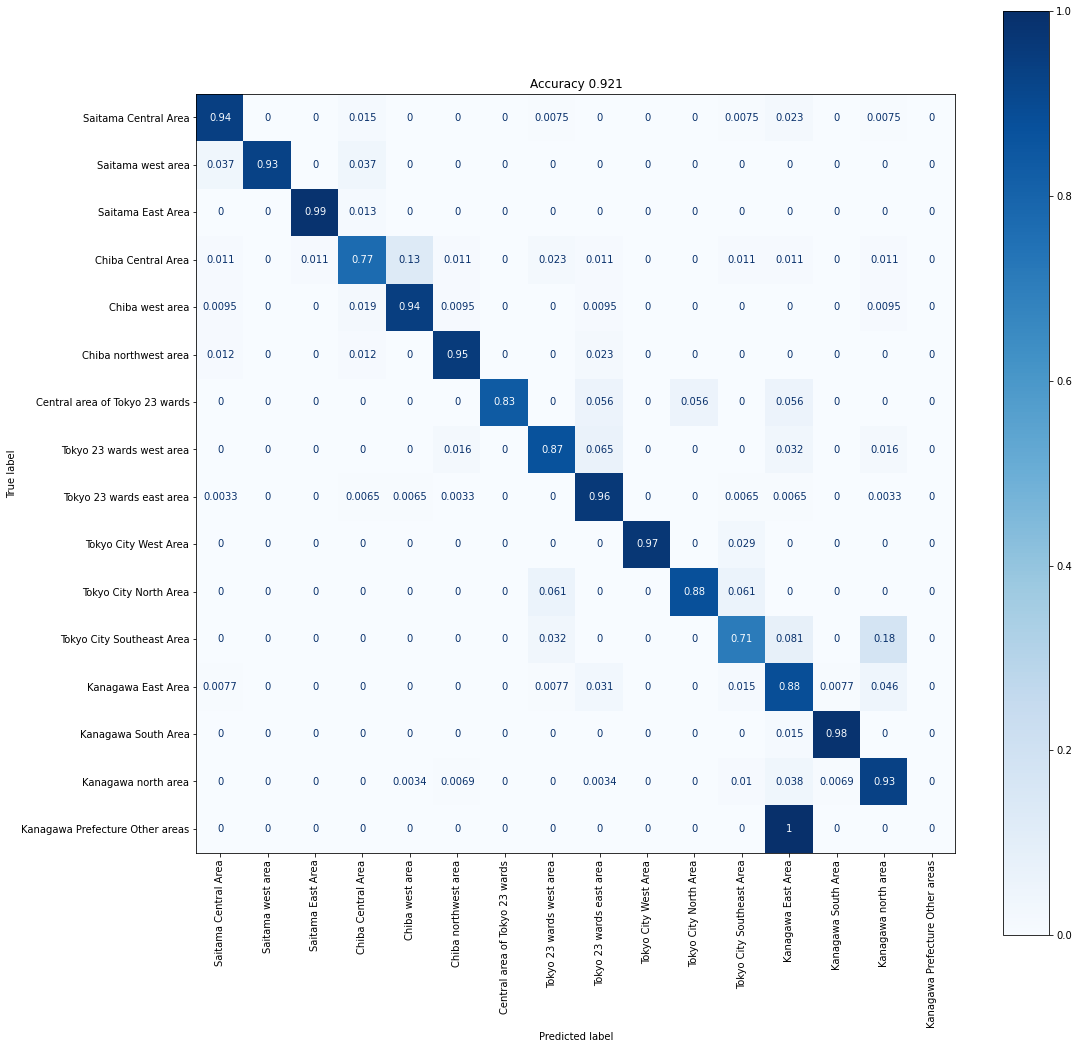

In [27]:
area = {'1101':'Saitama Central Area',
        '1102':'Saitama west area',
        '1103':'Saitama East Area',
        '1199':'Saitama Prefecture Other Areas',
        '1201':'Chiba Central Area',
        '1202':'Chiba west area',
        '1208':'Chiba northwest area',
        '1299':'Chiba Prefecture Other areas',
        '1301':'Central area of Tokyo 23 wards',
        '1302':'Tokyo 23 wards west area',
        '1303':'Tokyo 23 wards east area',
        '1312':'Tokyo City West Area',
        '1315':'Tokyo City North Area',
        '1317':'Tokyo City Southeast Area',
        '1399':'Tokyo Other Area',
        '1403':'Kanagawa East Area',
        '1404':'Kanagawa South Area',
        '1405':'Kanagawa north area',
        '1499':'Kanagawa Prefecture Other areas'}

fig, ax = plt.subplots(figsize=(17, 17))
plot_confusion_matrix(xgb_model_search_area,
                      X_val_search_area,
                      y_val_search_area,
                      normalize='true',
                      cmap=plt.cm.Blues,
                      ax=ax)

label = [area[str(i)] for i in np.unique(y_val_search_area)]
ax.set_xticklabels(label,rotation=90)
ax.set_yticklabels(label)

plt.title('Accuracy %s'%(round(accuracy_search_area,3)))
plt.show()

# ID validation

In [28]:
# id_dict = {'user_val_id': id_val_score}

# with open(os.path.join(base_eval,'user_id_val.json'), 'w') as outfile:
#     json.dump(id_dict, outfile)